In [31]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 


from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.datasets import load_diabetes,load_boston
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from graph_utils import plot_multiple,plot_xy

%matplotlib inline


# DATA PREPARATION

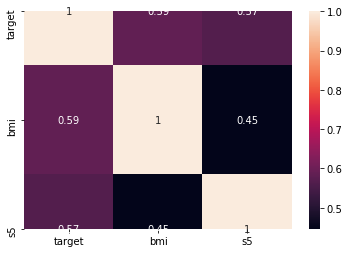

In [35]:
df = pd.DataFrame(load_diabetes().data, columns=load_diabetes().feature_names)
df["target"] = load_diabetes().target

correlated_features = abs(df.corr()["target"]).sort_values(ascending=False)

correlated_features = correlated_features[correlated_features>0.5]

df = df[correlated_features.keys()]

sns.heatmap(df.corr(),annot=True)

In [36]:
df

,target,bmi,s5
0,151.0,0.061696,0.019908
1,75.0,-0.051474,-0.068330
2,141.0,0.044451,0.002864
3,206.0,-0.011595,0.022692
4,135.0,-0.036385,-0.031991
...,...,...,...
437,178.0,0.019662,0.031193
438,104.0,-0.015906,-0.018118
439,132.0,-0.015906,-0.046879
440,220.0,0.039062,0.044528


In [37]:
file_path = None

if not(file_path):
    X = np.array(df.drop('target',axis=1))
    y = np.array(df["target"])
else:
    df = pd.read_csv(file_path,keep_default_na=False,na_values="").drop("Unnamed: 0",axis=1)

df = pd.DataFrame(X)

for i in range(len(df.columns)-1):
    name = str(df.columns[i])+"_x_"+str(df.columns[i+1])
    df[name] = df[df.columns[i]] * df[df.columns[i+1]]

X = np.array(df)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=31)
print('Train set size',X_train.shape[0],'Test set size',X_test.shape[0])

Train set size 88 Test set size 354


In [40]:
def standardize(df,df_ref):
    return (df - df_ref.mean())/df_ref.std(ddof=1)

def destandardize(df,df_ref):
    return (df * df_ref.std(ddof=1)) + df_ref.mean()

X_train_t = np.transpose(X_train.copy())
X_test_t = np.transpose(X_test.copy())

for i,col in enumerate(X_train_t) :
    X_test_t[i] = standardize(X_test_t[i], col)
    X_train_t[i] = standardize(col, col)
    
X_train_modified = np.transpose(X_train_t)
X_test_modified = np.transpose(X_test_t)

y_train_modified = standardize(y_train,y_train)
y_test_modified = standardize(y_test,y_train)

# REGRESSIONS

In [41]:
def train_model(model,X_train,y_train,X_test,y_test,GS=False):
    reg = model.fit(np.array(X_train), y_train)
    if GS:
        print(model.best_params_)
    for i in range(X_test.shape[0]):
        y_hat_test = reg.predict(np.array(X_test))
        y_hat_train = reg.predict(np.array(X_train))
    return y_hat_test,y_hat_train

def run_models(X_train,y_train,X_test,y_test,models,GS=False,y_hat=None,y_hat_train=None):
    if not(y_hat):
        y_hat = {}
    if not(y_hat_train):
        y_hat_train = {}
    for model_name in models.keys():
        y_hat[model_name],y_hat_train[model_name] = train_model(models[model_name],X_train,y_train,X_test,y_test,GS=GS)  

    return y_hat,y_hat_train

def compute_mse(y_test,y_hat,dict_mse=None):
    if not(dict_mse):
        dict_mse = {}
    for model_name in models.keys():
        dict_mse[model_name] = r2_score(np.array(y_test).reshape(-1,1),np.array(y_hat[model_name]))
        
    return dict_mse

In [42]:
models = {"Logisitc":LogisticRegression(),
          "Ridge":Ridge(),
          "Lasso":Lasso(),
          "Elastic Net":ElasticNet(),
          "LGBM":LGBMRegressor(n_estimators=2000),
          "MLP":MLPRegressor()}

y_hat,y_hat_train = run_models(X_train,y_train,X_test,y_test,models)


dict_mse=compute_mse(y_test,y_hat)
dict_mse_train=compute_mse(y_train,y_hat_train)

y_hat_modified,y_hat_modified_train = run_models(X_train_modified,y_train_modified,X_test_modified,y_test_modified,models)
for model_name in models.keys():
    y_hat_modified[model_name] = destandardize(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = destandardize(y_hat_modified_train[model_name],y_train)
dict_mse_modified = compute_mse(y_test,y_hat_modified)
dict_mse_modified_train = compute_mse(y_train,y_hat_modified_train)



/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [43]:
dict_mse_train

{'Linear': 0.3539809821660558,
 'Ridge': 0.12867933732442993,
 'Lasso': 0.23230622017471436,
 'Elastic Net': 0.002874041105306535,
 'LGBM': 0.6507521345474712,
 'MLP': -5.296143250378522}

In [44]:
dict_mse

{'Linear': 0.43783846604993815,
 'Ridge': 0.05045534620718206,
 'Lasso': 0.1650382996931774,
 'Elastic Net': -0.13442769106097674,
 'LGBM': 0.08827183154462281,
 'MLP': -3.4458423524018453}

Linear


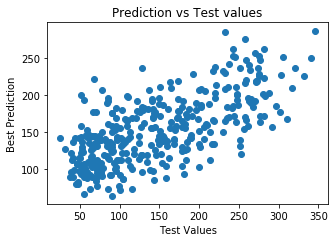

In [45]:
best_model = max(dict_mse, key=dict_mse.get)
print(best_model)

Series = [y_test,y_hat[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

In [46]:
dict_mse_modified_train

{'Linear': 0.3539809821660558,
 'Ridge': 0.35395015731534585,
 'Lasso': 0.0,
 'Elastic Net': 0.0361915403982036,
 'LGBM': 0.654329970439073,
 'MLP': 0.4046467738356565}

In [47]:
dict_mse_modified

{'Linear': 0.4378384660499379,
 'Ridge': 0.43679514995041724,
 'Lasso': -0.13849913663084612,
 'Elastic Net': -0.09359841909776634,
 'LGBM': 0.1323768429844172,
 'MLP': 0.44051886616613023}

MLP


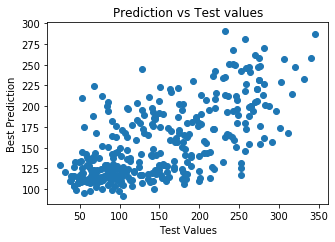

In [48]:
best_model = max(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)

Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

# GridSearch

In [49]:

param_grid = {}
n_splits = 5

# MLP

In [50]:
param_grid["MLP"] = {
    'hidden_layer_sizes':[(i,) for i in range(100,1000,100)],
    'activation':['identity', 'tanh', 'relu'],
    'solver':["adam"],
    'learning_rate':["adaptive"],
    'max_iter':[20000],
    'early_stopping':[True],
    'alpha':[10**(-i) for i in range(0,6)]
    
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
MLP_GS = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid["MLP"], cv=gkf,verbose=1)

## LGBM

In [51]:
param_grid["LGBM"] = {
    'boosting_type':["gbdt"],
    'max_depth': [-1],
    'n_estimators':[2000],
    'reg_alpha':[0],
    'reg_lambda':[0],
    'num_leaves':[i for i in range(2,100,2)],
    'learning_rate':[10**(-i) for i in range(0,3)],
    'subsample':[0.95],
    'colsample_bytree':[0.95]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
LGBM_GS = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid["LGBM"], cv=gkf,verbose=1)

## Ridge

In [52]:
param_grid["Ridge"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Ridge_GS = GridSearchCV(estimator=Ridge(), param_grid=param_grid["Ridge"], cv=gkf,verbose=1)

## Lasso

In [53]:
param_grid["Lasso"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Lasso_GS = GridSearchCV(estimator=Lasso(), param_grid=param_grid["Lasso"], cv=gkf,verbose=1)

## Logistic regression

In [ ]:
param_grid["ElasticNet"] = {
    'penalty':['l1','l2','elasticnet'],
    'C':[i/10 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
ElasticNet_GS = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid["ElasticNet"], cv=gkf,verbose=0)

## ElasticNet

In [54]:
param_grid["ElasticNet"] = {
    'alpha':[i/100 for i in range(1,100)],
    'l1_ratio':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
ElasticNet_GS = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid["ElasticNet"], cv=gkf,verbose=0)

In [55]:
models = {"LGBM GS":LGBM_GS,
          "Ridge GS":Ridge_GS,
          "Lasso GS":Lasso_GS,
          "ElasticNet GS":ElasticNet_GS,
          'MLP GS':MLP_GS
         }




In [56]:
y_hat_modified, y_hat_modified_train = run_models(X_train_modified,
                                                  y_train_modified,
                                                  X_test_modified,
                                                  y_test_modified,
                                                  models,
                                                  GS=True,
                                                  y_hat=y_hat_modified,
                                                  y_hat_train=y_hat_modified_train)
for model_name in models.keys():
    y_hat_modified[model_name] = destandardize(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = destandardize(y_hat_modified_train[model_name],y_train)
dict_mse_modified=compute_mse(y_test,y_hat_modified,dict_mse=dict_mse_modified)
dict_mse_modified_train=compute_mse(y_train,y_hat_modified_train,dict_mse=dict_mse_modified_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:  1.6min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.95, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 2000, 'num_leaves': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.95}
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.99}
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.6s finished


{'alpha': 0.01}
{'alpha': 0.04, 'l1_ratio': 0.01}
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'activation': 'identity', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 20000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:   28.6s finished


# RESULTS

In [57]:
dict_mse_modified_train

{'Linear': 0.3539809821660558,
 'Ridge': 0.35395015731534585,
 'Lasso': 0.0,
 'Elastic Net': 0.0361915403982036,
 'LGBM': 0.654329970439073,
 'MLP': 0.4046467738356565,
 'LGBM GS': 0.4412064321597229,
 'Ridge GS': 0.3539507645100425,
 'Lasso GS': 0.35382682650425323,
 'ElasticNet GS': 0.3536085486927608,
 'MLP GS': 0.3497043410880667}

In [58]:
dict_mse_modified

{'Linear': 0.4378384660499379,
 'Ridge': 0.43679514995041724,
 'Lasso': -0.13849913663084612,
 'Elastic Net': -0.09359841909776634,
 'LGBM': 0.1323768429844172,
 'MLP': 0.44051886616613023,
 'LGBM GS': 0.3730638169860324,
 'Ridge GS': 0.4368058739682189,
 'Lasso GS': 0.43359126511816426,
 'ElasticNet GS': 0.4337849241613826,
 'MLP GS': 0.40368610169289865}

MLP


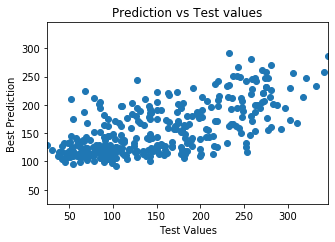

In [59]:
best_model = max(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)
Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter",same_xy=True)

In [103]:
param_grid_list = {
    "horizon": [25,26,27],
    "agent": ["dueling_dqn"],
    "memory": [10000],
    "network": ["auto"],
    "size": [256],
    "depth": [2],
    "exploration": [0.05],
    "batch_size": [32],
    "discount": [0.1],
    "seed": [124],
    "estimate_terminals": [True],
}

lists = param_grid_list.values()

In [104]:
param_combinations = list(itertools.product(*lists))
total_param_combinations = len(param_combinations)

In [106]:
param_combinations[0]

(25, 'dueling_dqn', 10000, 'auto', 256, 2, 0.05, 32, 0.1, 124, True)